In [113]:
import torch
import torchvision
import torchvision.utils as vutils
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
###

In [36]:
transform = torchvision.transforms.Compose([
    # you can add other transformations in this list
    torchvision.transforms.Resize(64),
    torchvision.transforms.ToTensor()
])
mnist_data = torchvision.datasets.MNIST(root='',download=True,transform=transform)

In [37]:
data_loader = torch.utils.data.DataLoader(mnist_data,batch_size=32,shuffle=True,)

In [49]:
test = next(iter(data_loader))
test = test[0][0]
test = test.reshape((64,64,1))

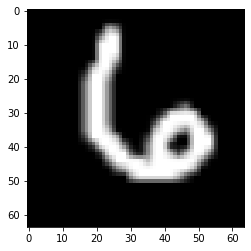

In [50]:
plt.imshow(test,cmap='gray')

In [31]:
### Now time for Generator and Discriminator

In [51]:
batch_size = 32
number_channels = 1
number_latent = 50
ngf = 64
ndf = 64
num_epochs = 10
lr = 0.0002
beta1 = 0.5

In [56]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(number_latent,ngf*8,4,1,bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            #channels*dim*dim = (ngf*8) * 4 * 4
            nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            #channels*dim*dim = (ngf*4) * 8 *8,
            nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            #channels*dim*dim = (ngf*2) * 16 * 16
            nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #channels*dim*dim = ngf * 32 * 32
            nn.ConvTranspose2d(ngf,number_channels,4,2,1,bias=False),
            nn.Sigmoid()
            #channes*dim*dim = number_channels * 64 * 64
        )
        
    def forward(self,x):
        return self.model(x)

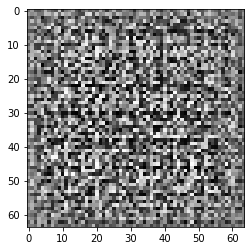

In [104]:
# TESTING THAT GENERATOR PRODUCES AN IMAGE OF THE CORRECT SIZE/SHAPE
netG = Generator()
noise = np.random.normal(size=(1,50,1,1))
noise = torch.from_numpy(noise).float()
test_output = netG(noise)
test_img = test_output[0].detach().numpy().reshape((64,64))
plt.imshow(test_img,cmap='gray')

In [100]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
        #input shape = number_channels * 64 * 64
        nn.Conv2d(number_channels,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        # ndf * 32 * 32
        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,inplace=True),
        # (ndf*2) * 16 * 16
        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,inplace=True),
        # (ndf*4) * 8 * 8
        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2,inplace=True),
        # (ndf*8) * 4 * 4
        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        nn.Flatten(),
        nn.Sigmoid()
        )
    def forward(self,x):
        return self.model(x)

In [110]:
# TESTING THAT THE DISCRIMINATOR WORKS PROPERLY
netD = Discriminator()
test_discrim = netD(test_output)
print(test_discrim)

tensor([[0.5065]], grad_fn=<SigmoidBackward>)


In [112]:
criterion = nn.BCELoss()

fixed_noise = np.random.normal(size=(1,number_latent,1,1))
fixed_noise = torch.from_numpy(fixed_noise).float()

real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(netD.parameters(),lr=lr,betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(),lr=lr,betas=(beta1, 0.999))

In [132]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    # for each batch in the dataloader
    for i, data in enumerate(data_loader,0):
        # UPDATE D TO MAXIMIZE log(D(x)) + log(1 - D(G(z)))
        ## FIRST TRAIN WITH ALL REAL IMAGES BATCH
        netD.zero_grad()
        use_data = data[0]
        #label = np.ones((batch_size,1))
       # label = torch.from_numpy(label).float()
        label = torch.full((batch_size,1), real_label, dtype=torch.float)
        # Forward pass the batch for real images, through D
        output = netD(use_data)
        errD_real = criterion(output,label)
        # Calculate gradients for D with a backwards pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## NOW TRAIN D WITH AN ALL FAKE IMAGES BATCH
        noise = np.random.normal(size=(batch_size,50,1,1))
        noise = torch.from_numpy(noise).float()
        # GENERATE BATCH OF FAKE IMAGES, USING G
        fake = netG(noise)
        label.fill_(fake_label)
        # CLASSIFY THE FAKE BATCH USING D
        output = netD(fake.detach())
        # Calculate loss for D on the all-fake batch
        errD_fake = criterion(output,label)
        # Calculate gradients for this batch, accumulated (summed) w the previous batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as the sum over fake and real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        #--------------------------------------
        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label) # fake labels are considered real for the generator loss
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake)
        # Calculate loss for G based on this output
        errG = criterion(output,label) # If it's all correct, you did good because D thinks you're real
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Print training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1

[0/10][0/1875]	Loss_D: 0.3671	Loss_G: 5.2163	D(x): 0.9666	D(G(z)): 0.2716 / 0.0057
[0/10][50/1875]	Loss_D: 0.0474	Loss_G: 6.1330	D(x): 0.9780	D(G(z)): 0.0243 / 0.0024
[0/10][100/1875]	Loss_D: 0.3950	Loss_G: 4.8163	D(x): 0.7371	D(G(z)): 0.0342 / 0.0173
[0/10][150/1875]	Loss_D: 0.4359	Loss_G: 3.3584	D(x): 0.7822	D(G(z)): 0.1027 / 0.0452
[0/10][200/1875]	Loss_D: 0.5603	Loss_G: 1.9713	D(x): 0.7555	D(G(z)): 0.1889 / 0.1666
[0/10][250/1875]	Loss_D: 0.5996	Loss_G: 1.1833	D(x): 0.6447	D(G(z)): 0.0836 / 0.3513
[0/10][300/1875]	Loss_D: 1.1410	Loss_G: 0.6969	D(x): 0.4344	D(G(z)): 0.1035 / 0.5451
[0/10][350/1875]	Loss_D: 0.7481	Loss_G: 1.1386	D(x): 0.6464	D(G(z)): 0.2267 / 0.3540
[0/10][400/1875]	Loss_D: 0.6822	Loss_G: 1.6283	D(x): 0.7187	D(G(z)): 0.2608 / 0.2337
[0/10][450/1875]	Loss_D: 0.8252	Loss_G: 1.4173	D(x): 0.6041	D(G(z)): 0.2060 / 0.2684
[0/10][500/1875]	Loss_D: 1.5173	Loss_G: 2.4487	D(x): 0.8899	D(G(z)): 0.6980 / 0.0990
[0/10][550/1875]	Loss_D: 1.2294	Loss_G: 2.8990	D(x): 0.8462	D(G(z)):

KeyboardInterrupt: 

In [ ]:
#If there is a keyboard interrupt error above, it means that I manually stopped training
# because I didn't think that more was needed

# Check out the results below!

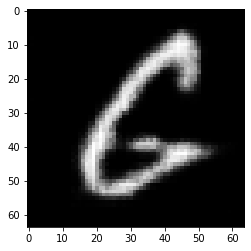

In [146]:
# RUN THIS CELL TO GENERATE IMAGES USING THE GENERATOR (after training)
noise = np.random.normal(size=(1,50,1,1))
noise = torch.from_numpy(noise).float()
test_output = netG(noise)
test_img = test_output[0].detach().numpy().reshape((64,64))
plt.imshow(test_img,cmap='gray')